# Quickstart Example of Off-Policy Evaluation with Various Estimators (Discrete)
This notebook provides an example of conducting **Off-policy Evaluation (OPE)** with a synthetic recommendation (REC) dataset and various OPE estimators (e.g., model-based vs importance sampling-based, marginal importance sampling, and double reinforcement learning).

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Off-Policy Evaluation (OPE) with various estimators

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [34]:
# delete later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# delete later
import warnings
warnings.simplefilter("ignore")

In [36]:
# delete later
import sys
sys.path.append("../")
sys.path.append("../../")

In [37]:
# import OFRL modules
import ofrl
from recgym import RECEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead
from ofrl.policy import DiscreteEpsilonGreedyHead as EpsilonGreedyHead
from ofrl.policy import DiscreteSoftmaxHead as SoftmaxHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy as RandomPolicy

# from d3rlpy.preprocessing import MinMaxScaler
from ofrl.utils import MinMaxScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split


In [38]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [39]:
# version
print(ofrl.__version__)


0.0.0


In [40]:
# set random state
random_state = 12345

In [41]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the recommender environment works.

#### RL setup for recommendation
In recommendation, the objective of the RL agent is to maximize reward.

We often formulate this recommendation problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: 
   - A vector representing user preference.  The preference changes over time in an episode by the actions presented by the RL agent.
   - When the true state is unobservable, the agent uses observation instead of state.
- `action`: Indicating which item to present to the user.
- `reward`: User engagement signal. Either binary or continuous.

For more about the environmental configuration and its customization, please refer to [examples/quickstart/rec_synthetic_customize_env.ipynb](https://github.com/negocia-inc/rec_reinforcement_learing/blob/ope/examples/quickstart/rec_synthetic_customize_env.ipynb).

In [42]:
# standardized environment
env = gym.make("RECEnv-v0")

In [43]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

#### Synthetic Data Generation
Next, we collect logged data with a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

`SyntheticDataset` has the following arguments:
- `env`: Recommender environment for RL defined in the previous section.
- `max_episode_steps`: Maximum number of timesteps in an episode.

For more about the data collection and visualization, please refer to [examples/quickstart/rec/rec_synthetic_data_collection.ipynb](https://github.com/negocia-inc/ofrl/blob/ope/examples/quickstart/rec/rec_synthetic_data_collection.ipynb).

In [44]:
# behavior policy
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)


In [45]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env_,
    buffer,
    explorer=explorer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)


2023-02-01 17:56.35 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230201175635
2023-02-01 17:56.35 [debug    ] Building model...
2023-02-01 17:56.35 [debug    ] Model has been built.
2023-02-01 17:56.35 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230201175635/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (5,), 'action_s

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-02-01 17:56.36 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230201175635/model_1000.pt
2023-02-01 17:56.36 [info     ] DoubleDQN_online_20230201175635: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.00011333537101745605, 'time_environment_step': 1.7141342163085938e-05, 'time_step': 0.00013782668113708496, 'rollout_return': -0.08529244693876656, 'evaluation': -0.22803182189697263} step=1000
2023-02-01 17:56.36 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230201175635/model_2000.pt
2023-02-01 17:56.36 [info     ] DoubleDQN_online_20230201175635: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.0001254582405090332, 'time_environment_step': 2.2466659545898437e-05, 'time_sample_batch': 2.652168273925781e-05, 'time_algorithm_update': 0.000620100736618042, 'loss': 0.02057397326733917, 'time_step': 0.0008093991279602051, 'rollout_return': 0.03330441413522307, 'evaluation': 0.7261684572128987} step=2000
2023-02-01 17:56.

In [46]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [47]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

2023-02-01 17:57.59 [warning  ] Parameters will be reinitialized.


In [48]:
behavior_policy = EpsilonGreedyHead(
    ddqn,
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [49]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [50]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000,
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000,
    obtain_info=False,
    random_state=random_state,
)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [51]:
with open("logs/train_dataset_discrete_ddpn.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_discrete_ddpn.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [52]:
with open("logs/train_dataset_discrete_ddpn.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_discrete_ddpn.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/rec/rec_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/ofrl/blob/ope/examples/quickstart/rec/rec_synthetic_discrete_basic.ipynb).

In [53]:
# import modules from d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQL as CQL

# transform offline dataset for d3rlpy
offlinerl_dataset = MDPDataset(
    observations=train_logged_dataset["state"],
    actions=train_logged_dataset["action"],
    rewards=train_logged_dataset["reward"],
    terminals=train_logged_dataset["done"],
    episode_terminals=train_logged_dataset["done"],
    discrete_action=True,
)
train_episodes, test_episodes = train_test_split(
    offlinerl_dataset, test_size=0.2, random_state=random_state
)

In [54]:
# Use Conservative Q-Learning policy
cql = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

In [55]:
cql.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

2023-02-01 17:58.44 [debug    ] RandomIterator is selected.
2023-02-01 17:58.44 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201175844
2023-02-01 17:58.44 [debug    ] Building models...
2023-02-01 17:58.44 [debug    ] Models have been built.
2023-02-01 17:58.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201175844/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 17:58.54 [info     ] DiscreteCQL_20230201175844: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.744511127471923e-05, 'time_algorithm_update': 0.0009133398294448853, 'loss': 3.9732159007549286, 'time_step': 0.0010306868314743042} step=10000
2023-02-01 17:58.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201175844/model_10000.pt


[(1,
  {'time_sample_batch': 6.744511127471923e-05,
   'time_algorithm_update': 0.0009133398294448853,
   'loss': 3.9732159007549286,
   'time_step': 0.0010306868314743042})]

In [56]:
# save model
cql.save_model("d3rlpy_logs/cql_discrete.pt")

In [57]:
# reload model
cql.build_with_env(env_)
cql.load_model("d3rlpy_logs/cql_discrete.pt")

2023-02-01 17:58.54 [warning  ] Parameters will be reinitialized.


## 2. Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner using (basic) model-based and importance sampling-based estimators.

#### Estimation Target

The goal to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [58]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput
from ofrl.ope import OffPolicyEvaluation as OPE

# basic estimators
from ofrl.ope import DiscreteDirectMethod as DM
from ofrl.ope import DiscreteTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import DiscretePerDecisionImportanceSampling as PDIS
from ofrl.ope import DiscreteDoublyRobust as DR

# self normalized estimators
from ofrl.ope import DiscreteSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import DiscreteSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import DiscreteSelfNormalizedDoublyRobust as SNDR

# marginal estimators
from ofrl.ope import DiscreteStateActionMarginalImportanceSampling as SAMIS
from ofrl.ope import DiscreteStateActionMarginalDoublyRobust as SAMDR
from ofrl.ope import DiscreteStateMarginalImportanceSampling as SMIS
from ofrl.ope import DiscreteStateMarginalDoublyRobust as SMDR
from ofrl.ope import (
    DiscreteStateActionMarginalSelfNormalizedImportanceSampling as SAMSNIS,
)
from ofrl.ope import DiscreteStateActionMarginalSelfNormalizedDoublyRobust as SAMSNDR
from ofrl.ope import DiscreteStateMarginalSelfNormalizedImportanceSampling as SMSNIS
from ofrl.ope import DiscreteStateMarginalSelfNormalizedDoublyRobust as SMSNDR

# double reinforcement learning estimators
from ofrl.ope import DiscreteDoubleReinforcementLearning as DRL

In [59]:
from d3rlpy.algos import DiscreteRandomPolicy

random = DiscreteRandomPolicy()
random.build_with_env(env_)

In [60]:
# define evaluation policies
cql_ = EpsilonGreedyHead(
    base_policy=cql,
    n_actions=env.action_space.n,
    name="cql",
    epsilon=0.0,
    random_state=random_state,
)
ddqn_ = EpsilonGreedyHead(
    base_policy=ddqn,
    n_actions=env.action_space.n,
    name="ddqn",
    epsilon=0.0,
    random_state=random_state,
)
random_ = EpsilonGreedyHead(
    base_policy=random,
    n_actions=env.action_space.n,
    name="random",
    epsilon=1.0,
    random_state=random_state,
)
evaluation_policies = [cql_, ddqn_, random_]

In [61]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        },
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
    sigma=0.1,
    gamma=0.95,
    device="cuda:0" if torch.cuda.is_available() else "cpu",
)

In [62]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    require_weight_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

[fit FQE model]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 17:58.55 [debug    ] RoundIterator is selected.
2023-02-01 17:58.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201175855
2023-02-01 17:58.55 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 17:58.55 [debug    ] Building models...
2023-02-01 17:58.55 [debug    ] Models have been built.
2023-02-01 17:58.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201175855/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 17:58.56 [info     ] DiscreteFQE_20230201175855: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.712030410766602e-05, 'time_algorithm_update': 0.0007602341175079345, 'loss': 0.02126575858425349, 'time_step': 0.0008633184432983398} step=1000
2023-02-01 17:58.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201175855/model_1000.pt
2023-02-01 17:58.56 [debug    ] RoundIterator is selected.
2023-02-01 17:58.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201175856
2023-02-01 17:58.56 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 17:58.56 [debug    ] Building models...
2023-02-01 17:58.56 [debug    ] Models have been built.
2023-02-01 17:58.56 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201175856/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 17:58.57 [info     ] DiscreteFQE_20230201175856: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.559442520141601e-05, 'time_algorithm_update': 0.0007542991638183594, 'loss': 0.019656321205664427, 'time_step': 0.000856191635131836} step=1000
2023-02-01 17:58.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201175856/model_1000.pt
2023-02-01 17:58.57 [debug    ] RoundIterator is selected.
2023-02-01 17:58.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201175857
2023-02-01 17:58.57 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 17:58.57 [debug    ] Building models...
2023-02-01 17:58.57 [debug    ] Models have been built.
2023-02-01 17:58.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201175857/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 17:58.57 [info     ] DiscreteFQE_20230201175857: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.928943634033204e-05, 'time_algorithm_update': 0.0006499903202056885, 'loss': 0.012260290427599102, 'time_step': 0.0007604570388793946} step=1000
2023-02-01 17:58.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201175857/model_1000.pt


[fit MWL model]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [63]:
with open("logs/ope_input_dict_discrete_zoo.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [64]:
with open("logs/ope_input_dict_discrete_zoo.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [65]:
basic_estimators = [DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()]
state_marginal_estimators = [SMIS(), SMDR(), SMSNIS(), SMSNDR()]
state_action_marginal_estimators = [SAMIS(), SAMDR(), SAMSNIS(), SAMSNDR()]
drl_estimators = [DRL()]
all_estimators = (
    basic_estimators
    + state_marginal_estimators
    + state_action_marginal_estimators
    + drl_estimators
)

In [66]:
basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]

In [67]:
ope = OPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=all_estimators,
)

In [68]:
# policy value estimation by ope
(
    policy_value_df_dict,
    policy_value_interval_df_dict,
) = ope.summarize_off_policy_estimates(
    input_dict,
    random_state=random_state,
)
# dictionary of the estimation
policy_value_df_dict

{'cql':            policy_value  relative_policy_value
 on_policy      1.234121               1.000000
 dm             0.727557               0.589534
 tis            0.523368               0.424082
 pdis           0.868495               0.703735
 dr             1.263085               1.023469
 sntis          1.353493               1.096726
 snpdis         1.324539               1.073265
 sndr           1.332631               1.079822
 sm_is               NaN                    NaN
 sm_dr               NaN                    NaN
 sm_snis             NaN                    NaN
 sm_sndr             NaN                    NaN
 sam_is              NaN                    NaN
 sam_dr              NaN                    NaN
 sam_snis            NaN                    NaN
 sam_sndr            NaN                    NaN
 drl            0.728293               0.590131,
 'ddqn':            policy_value  relative_policy_value
 on_policy      1.228692               1.000000
 dm             0.690760

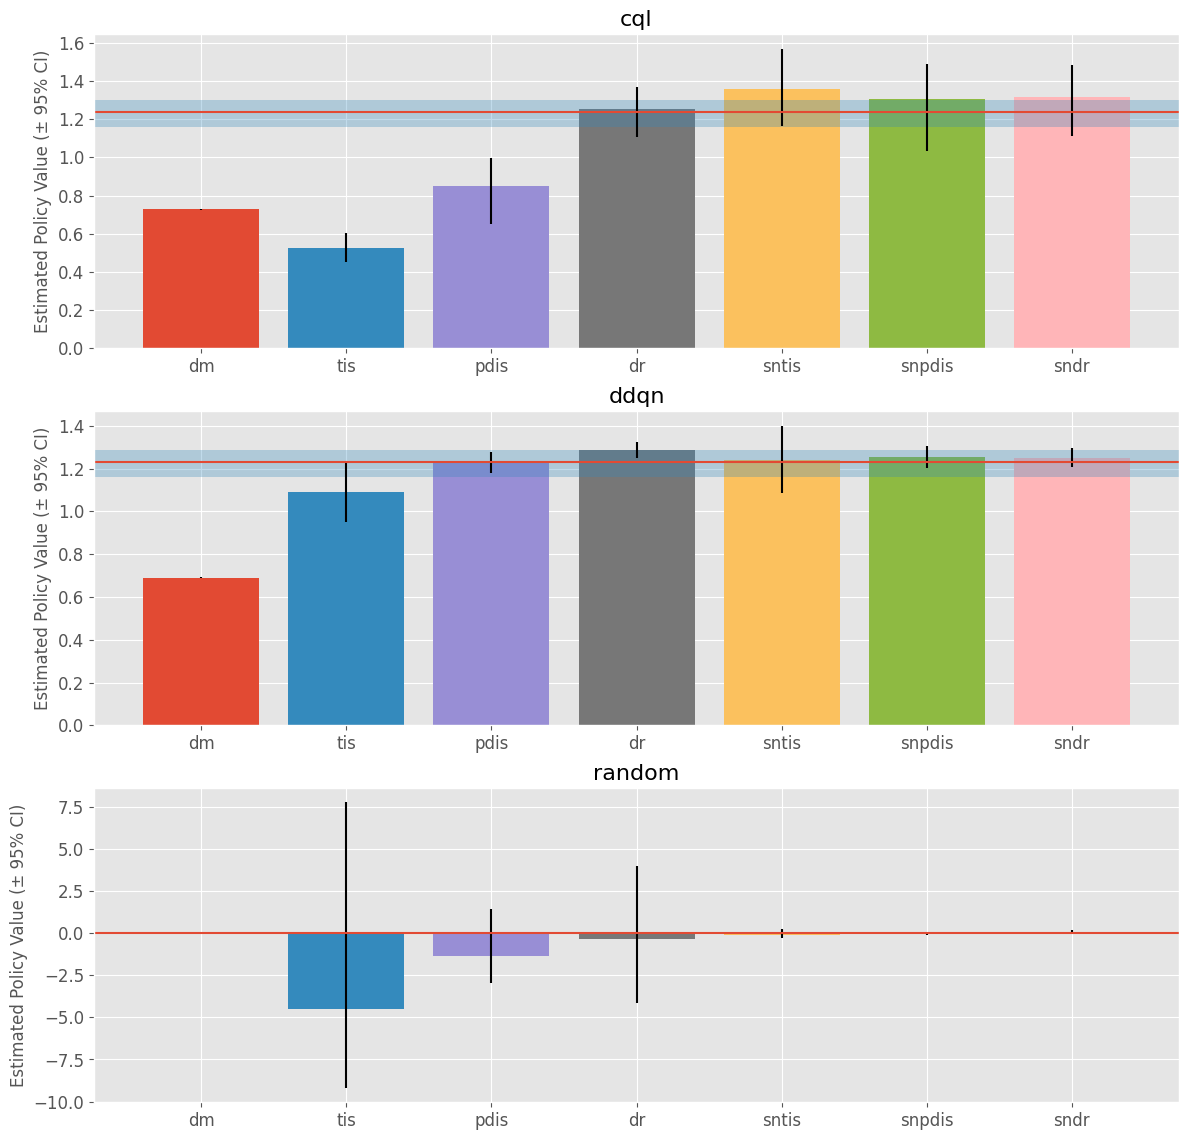

In [69]:
# visualize and compare the result
ope.visualize_off_policy_estimates(
    input_dict,
    compared_estimators=basic_estimators_name,
    random_state=random_state,
    sharey=False,
)
# relative policy value to the behavior policy
# ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, sharey=False)

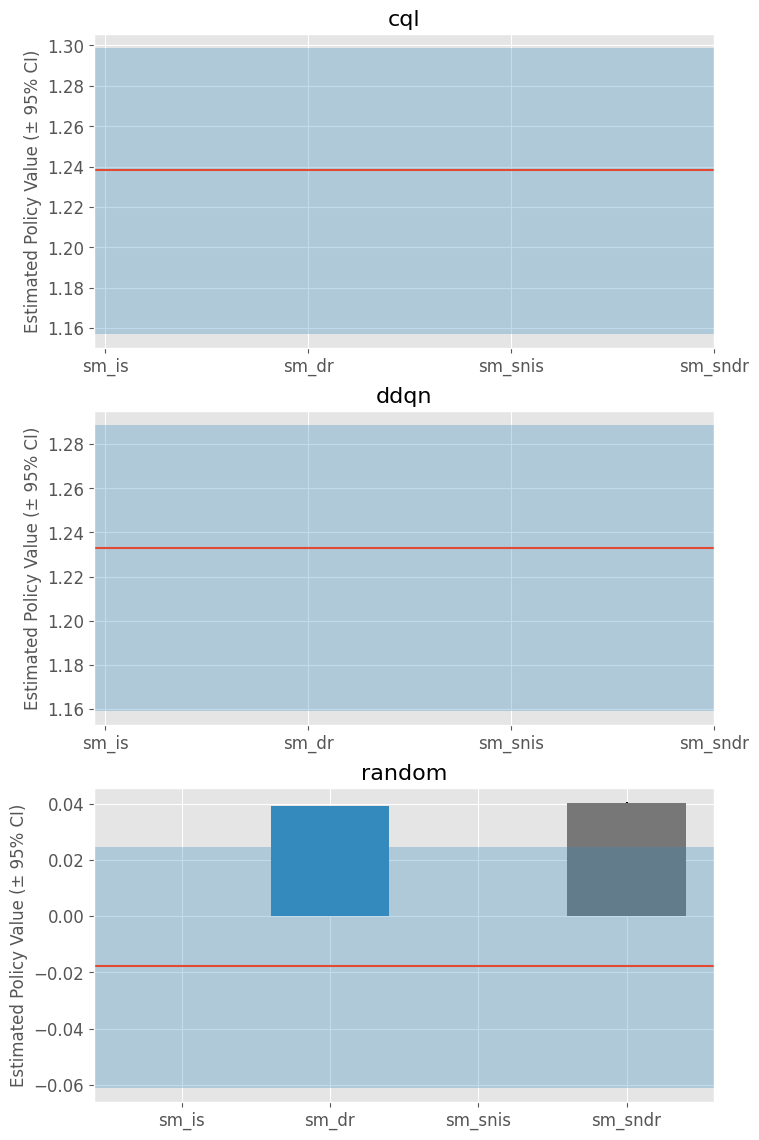

In [70]:
# visualize and compare the result
ope.visualize_off_policy_estimates(
    input_dict,
    compared_estimators=state_marginal_estimators_name,
    random_state=random_state,
    sharey=False,
)

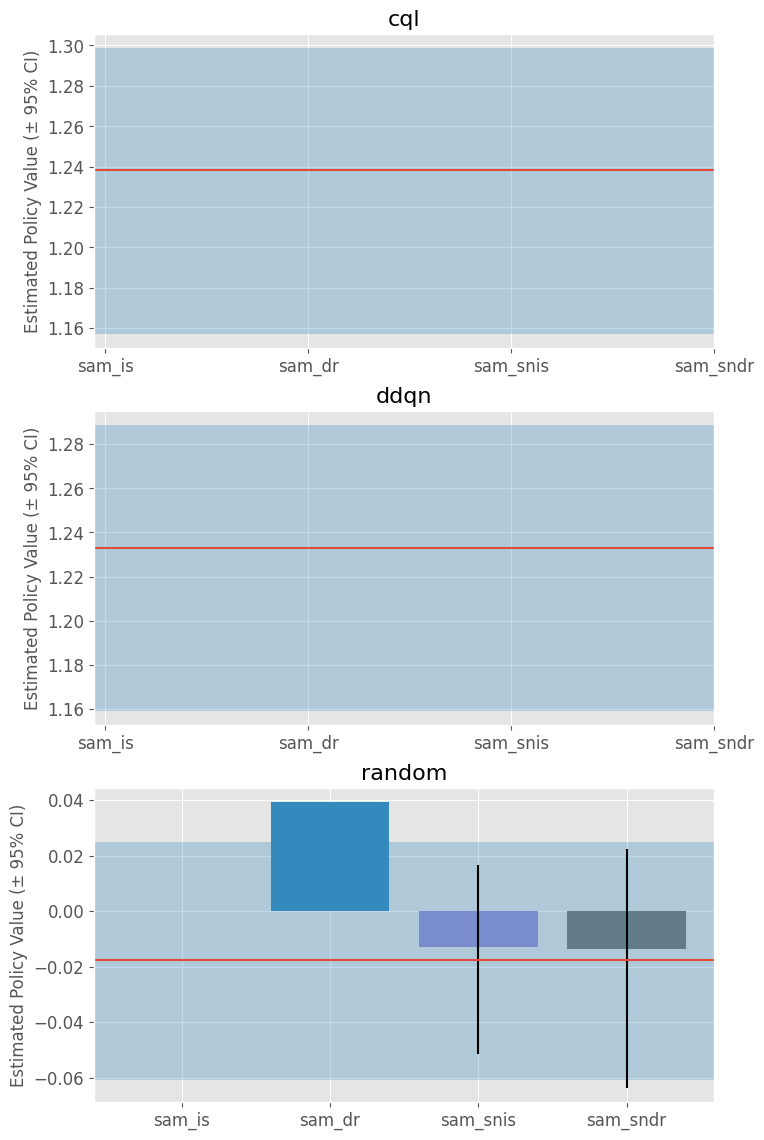

In [71]:
# visualize and compare the result
ope.visualize_off_policy_estimates(
    input_dict,
    compared_estimators=state_action_marginal_estimators_name,
    random_state=random_state,
    sharey=False,
)

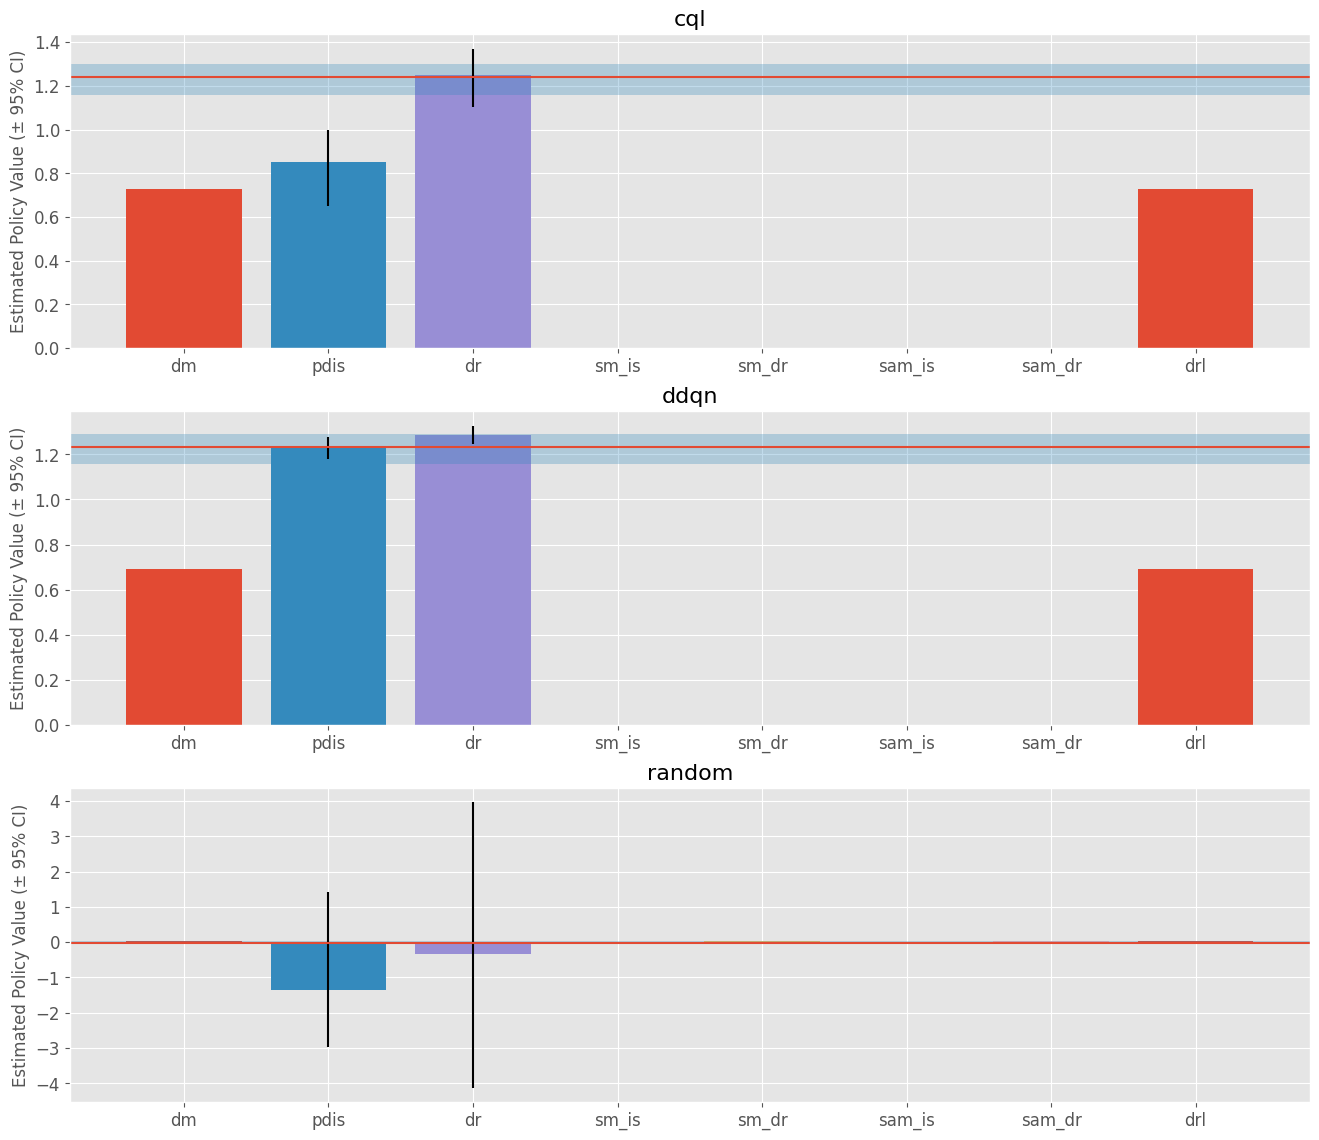

In [72]:
# visualize and compare the result
ope.visualize_off_policy_estimates(
    input_dict,
    compared_estimators=[
        "dm",
        "pdis",
        "dr",
        "sm_is",
        "sm_dr",
        "sam_is",
        "sam_dr",
        "drl",
    ],
    random_state=random_state,
    sharey=False,
)

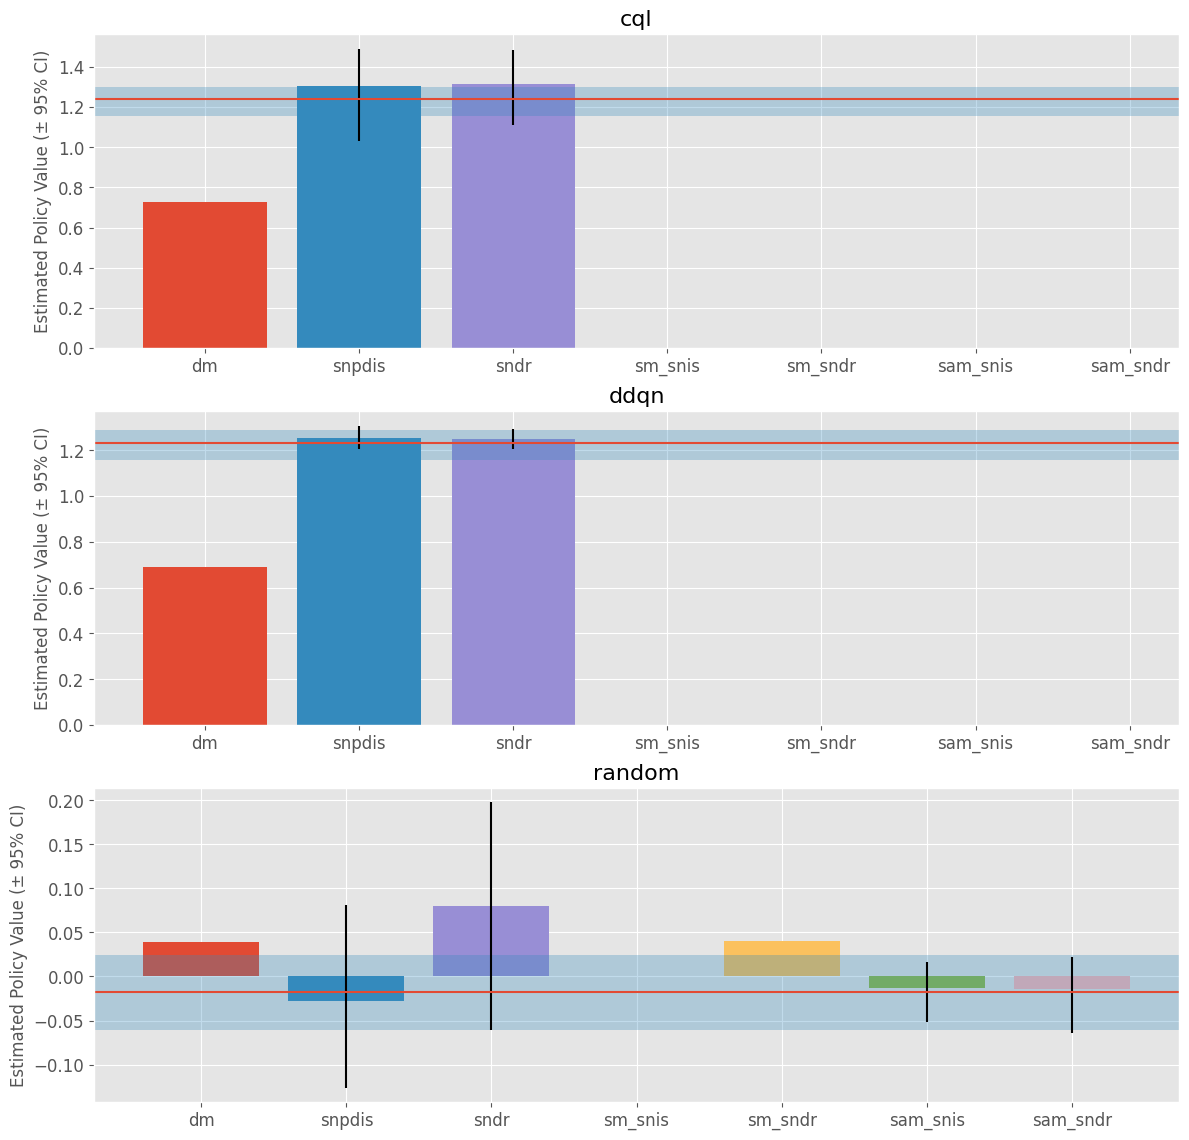

In [73]:
ope.visualize_off_policy_estimates(
    input_dict,
    compared_estimators=[
        "dm",
        "snpdis",
        "sndr",
        "sm_snis",
        "sm_sndr",
        "sam_snis",
        "sam_sndr",
    ],
    random_state=random_state,
    sharey=False,
)

For more advanced topics in OPE (e.g., cumulative distribution function estimation) and OPS, please refer to [examples/quickstart/rec/rec_synthetic_discrete_advanced.ipynb](https://github.com/negocia-inc/ofrl/blob/ope/examples/quickstart/rec/rec_synthetic_discrete_advanced.ipynb). 

<!-- For the examples in the continuous action space, please refer to [examples/quickstart/rec/rec_synthetic_continuous_zoo.ipynb](https://github.com/negocia-inc/ofrl/blob/ope/examples/quickstart/rec/rec_synthetic_continuous_zoo.ipynb). -->

## Reference

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Christina J. Yuan, Yash Chandak, Stephen Giguere, Philip S. Thomas, and Scott Niekum. \
"SOPE: Spectrum of Off-Policy Estimators.", 2021.

- Nathan Kallus and Masatoshi Uehara. \
"Double Reinforcement Learning for Efficient Off-Policy Evaluation in Markov Decision Processes.", 2020.

- Masatoshi Uehara, Jiawei Huang, and Nan Jiang. \
"Minimax Weight and Q-Function Learning for Off-Policy Evaluation.", 2020.

- Mengjiao Yang, Ofir Nachum, Bo Dai, Lihong Li, and Dale Schuurmans. \
"Off-Policy Evaluation via the Regularized Lagrangian.", 2020.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Qiang Liu, Lihong Li, Ziyang Tang, and Dengyong Zhou. \
"Breaking the Curse of Horizon: Infinite-Horizon Off-Policy Estimation.", 2018

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.